# Weather Forecast LSTM Model Training
## Variabel: Presipitasi (PRECTOTCORR)
#### Pujo Prayogo 140810200038 <br>

Best Hyperparameter: <br>
    LSTM Layers   : <br> 
    Unit          : <br>
    Activation    : <br>
    Learning Rate : <br>
    MAE (Tuning)  : <br>

R2 Score      : <br>
MAPE Score    : %

In [1]:
import pandas as pd
import numpy as np
import keras_tuner
import requests
import json
import matplotlib.pyplot as plt
import keras_tuner as kt
import model
import shutil
import os

from datetime import datetime, timedelta
from statsmodels.tsa.stattools import acf

from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.activations import relu, tanh, sigmoid
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Flatten, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Import Data

1. Define fitur variabel, tanggal, dan koordinat lokasi
2. Import data cuaca melalui data Lokal CSV
3. Rename nama kolom ke Bahasa Indonesia
4. Cek data & data NULL

In [2]:
# ----- Kode Parameter cuaca yang digunakan : GWETROOT, WS10M, PS, PRECTOTCORR, RH2M, T2M
feature = "GWETROOT"

# ----- Tanggal dan titik koordinat pengambilan data
start_date = "20200101"
end_date = "20241231"
lat = "-6.18"
long = "106.83"

# ----- Dict perubahan nama kolom 
renamed_dict = {
    "GWETROOT": "Kelembaban_Tanah",
    "WS10M": "Kecepatan_Angin",
    "PS": "Tekanan_Permukaan",
    "PRECTOTCORR": "Presipitasi",
    "RH2M": "Kelembaban_Udara",
    "T2M": "Temperatur"
}

# ----- variabel berisi nama fitur dengan Bahasa
feature_name = renamed_dict[feature]

# ----- Metrics tiap fitur
metrics_dict = {
    "GWETROOT": "", #Hanya 0-1
    "WS10M": "m/s",
    "PS": "kPa",
    "PRECTOTCORR": "mm/day",
    "RH2M": "C",
    "T2M": "g/kg"
}

# ----- Read data dari CSV 
df = pd.read_csv(f'Jakpus_{feature_name}_2020-2024.csv', sep=';', encoding='utf-8-sig')

# ----- Buat kolom tanggal dari YEAR dan DOY
df['DATE'] = pd.to_datetime(df['YEAR'].astype(str), format='%Y') + pd.to_timedelta(df['DOY'] - 1, unit='D')

# ----- Menjadikan DATE sebagai index, Hapus nama index
df.set_index('DATE', inplace=True)
df.index.name = None

# ----- Hapus kolom YEAR dan DOY
df.drop(columns=['YEAR', 'DOY'], inplace=True)

# ----- Rename kolom 
df.rename(columns={feature: feature_name}, inplace=True)

# ----- Cek Data
print(df.info(), '\n')
print(df, '\n\n')

# ----- Cek Data Invalid (Bernilai -999)
invalid_data = (df == -999).sum().sum()
print("TIDAK ADA DATA INVALID" if invalid_data == 0 else f"TERDAPAT DATA INVALID SEBANYAK {invalid_data} DATA")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2020-01-01 to 2024-12-31
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Kelembaban_Tanah  1827 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB
None 

            Kelembaban_Tanah
2020-01-01              0.78
2020-01-02              0.78
2020-01-03              0.78
2020-01-04              0.77
2020-01-05              0.76
...                      ...
2024-12-27              0.83
2024-12-28              0.83
2024-12-29              0.83
2024-12-30              0.83
2024-12-31              0.83

[1827 rows x 1 columns] 


TIDAK ADA DATA INVALID


#### Visualisasi data dalam grafik
Menampilkan grafik sebaran data asli sebelum difilter

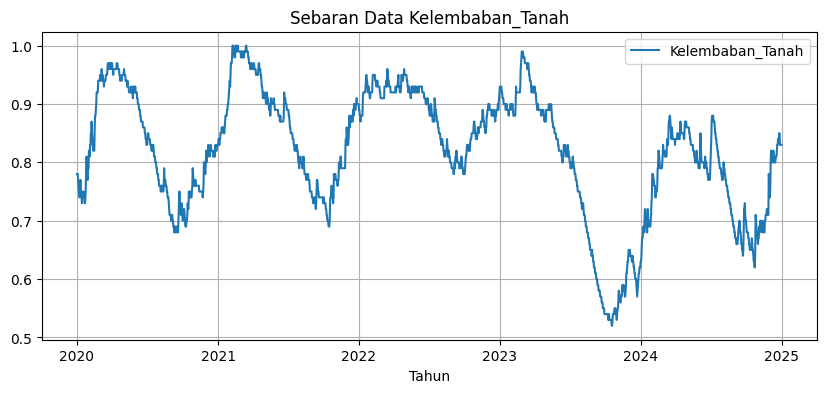

In [3]:
# ----- Visualisasi Data Asli
plt.figure(figsize=(10, 4))
plt.plot(df.index, df[feature_name], label=feature_name)
plt.xlabel('Tahun')
plt.ylabel(metrics_dict[feature])
plt.title(f'Sebaran Data {feature_name}')
plt.grid(True)
plt.legend()
plt.show()

In [4]:
# ----- Jika Import Data melalui API POWER NASA
#request_url = (
#    f"https://power.larc.nasa.gov/api/temporal/daily/point?"
#    f"start={start_date}&end={end_date}&latitude={lat}&longitude={long}&community=ag&"
#    f"parameters={feature}&format=json&user=pujo&header=true&time-standard=lst"
#)
#response = requests.get(url=request_url, verify=True, timeout=30.00)
#content = json.loads(response.content.decode('utf-8'))

# ----- Konversi data ke DataFrame
#df = pd.DataFrame.from_dict(content['properties']['parameter'])
#df.index = pd.to_datetime(df.index, format='%Y%m%d')

# ----- Rename Kolom
#df.rename(columns={feature: feature_name}, inplace=True)

# Data Cleaning (IQR)

Menghilangkan data yang tidak berada di antara lower bound dan upper bound (LB <= X >= UB)

In [5]:
# ------ Simpan Data asli sebelum terfilter untuk berjaga-jaga
df_real = df

# ----- IQR Data cleaning
Q1 = df[feature_name].quantile(0.25)
Q3 = df[feature_name].quantile(0.75)
IQR = Q3 - Q1

# ----- Menghapus outlier di luar 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR # (0.25)
upper_bound = Q3 + 1.5 * IQR # (0.75)
# ----- Print Outliers
outliers = df[(df[feature_name] <= lower_bound) | (df[feature_name] >= upper_bound)]
print(f"Outliers terhapus: {outliers.shape[0]} data ({(outliers.shape[0] / df.shape[0]) * 100:.2f}%)")
print(outliers.head())

df = df[(df[feature_name] >= lower_bound) & (df[feature_name] <= upper_bound)] # Df = Lowerbound >= DF <= Upperbound
print(f'data terfilter : {df}')

Outliers terhapus: 2 data (0.11%)
            Kelembaban_Tanah
2023-10-18              0.52
2023-10-19              0.52
data terfilter :             Kelembaban_Tanah
2020-01-01              0.78
2020-01-02              0.78
2020-01-03              0.78
2020-01-04              0.77
2020-01-05              0.76
...                      ...
2024-12-27              0.83
2024-12-28              0.83
2024-12-29              0.83
2024-12-30              0.83
2024-12-31              0.83

[1825 rows x 1 columns]


## Autokorelasi 
Menampilkan grafik autokorelasi dengan acf untuk menentukan timesteps. <br>
Timesteps yang diambil : <b>30

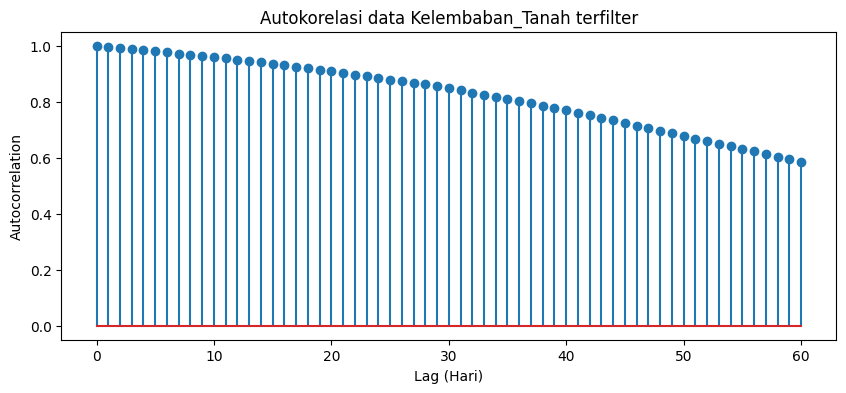

In [6]:
# ----- Autokorelasi untuk menentukan TImesteps
def determine_timesteps(df, max_lag=60):
    lag_acf = acf(df[feature_name], nlags=max_lag)

    # Visualisasi autokorelasi
    plt.figure(figsize=(10, 4))
    plt.stem(range(len(lag_acf)), lag_acf)
    plt.title(f'Autokorelasi data {feature_name} terfilter')
    plt.xlabel('Lag (Hari)')
    plt.ylabel('Autocorrelation')
    plt.show()

    return lag_acf

autocorrelation = determine_timesteps(df)

### Visualisasi Data yang telah terfilter & hasil Splitting 8:2

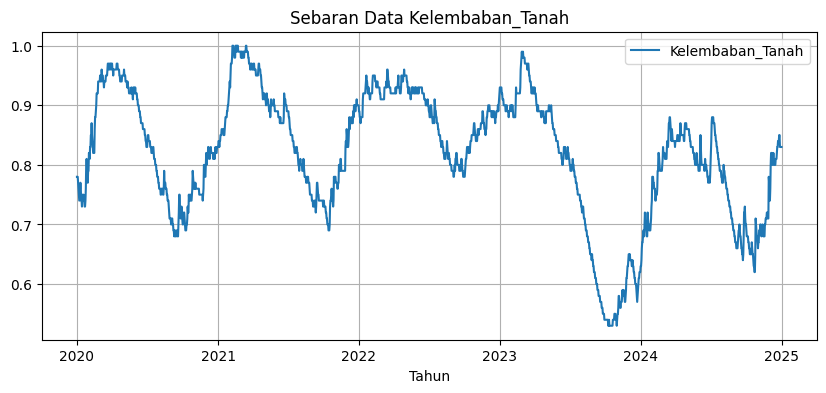

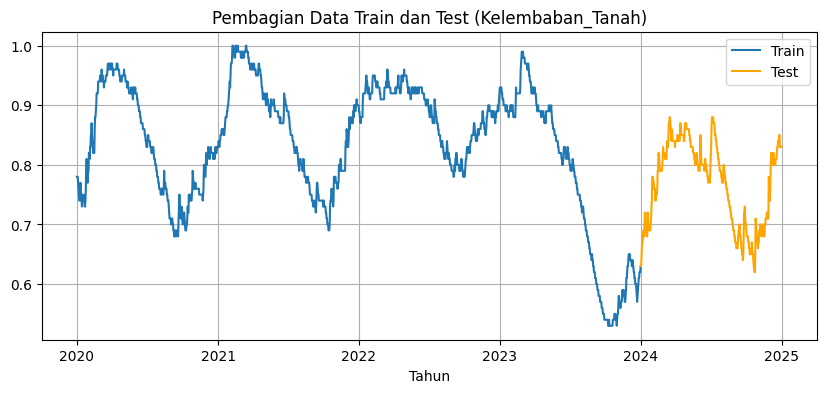

In [7]:
# ----- Visualisasi Data
plt.figure(figsize=(10, 4))
plt.plot(df.index, df[feature_name], label=feature_name)
plt.xlabel('Tahun')
plt.ylabel(metrics_dict[feature])  # Y-axis dinamis sesuai parameter
plt.title(f'Sebaran Data {feature_name}')
plt.grid(True)
plt.legend()
plt.show()

# ----- Visualisasi Train-Test Split Data Asli
X_train, X_test, y_train, y_test = train_test_split(
    df, df, test_size=0.2, shuffle=False
)

plt.figure(figsize=(10, 4))
plt.plot(df.index[:len(X_train)], X_train, label='Train')
plt.plot(df.index[len(X_train):], X_test, label='Test', color='orange')
plt.xlabel('Tahun')
plt.ylabel(metrics_dict[feature])
plt.title(f'Pembagian Data Train dan Test ({feature_name})')
plt.grid(True)
plt.legend()
plt.show()

## Data Scaling & Splitting 

1. Scaling dengan MinMax
2. Pembagian data menjadi data Training (80%) dan data Testing (20%) tanpa mengubah urutan data

x' = x - min(x) / max(x) - min(x) <br>
x = Data original

In [8]:
# ----- Normalisasi Data 
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# ----- Fungsi untuk Membuat Data Time-Series 
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# ----- Membuat Data Train & Test 
time_steps = 30  # Jumlah lag (window size)
X, y = create_sequences(df_scaled, time_steps)
split = int(0.8 * len(X))  # 80% Train, 20% Test
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ----- RESHAPE agar cocok untuk input LSTM: (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# ------ Simpan urutan terakhir dari dataset yang akan digunakan untuk prediksi masa depan
X_last_sequence = df_scaled[-time_steps:]

#### Membuat Directory untuk menyimpan hasil Tuning (Overwrite jika sudah ada) 

In [9]:
tuning_dir = f'lstm_tuning_{feature_name}_cleaned_dir'

# ----- Hapus Directory Tuning (hanya untuk Tuning ulang)
#if os.path.exists(tuning_dir):
#    shutil.rmtree(tuning_dir)
#    print(f"Directory file Tuning sebelumnya yang Terhapus: {tuning_dir}")
#else:
#     print(f"Directory File Tuning {tuning_dir} tidak ditemukan")

# Hyperparameter Tuning dengan KerasTuner
1. Membuat fungsi model LSTM:
   - Tuning jumlah layer LSTM (1 atau 2).
    - Tuning jumlah unit per layer (32, 64, atau 128).
    - Tuning fungsi aktivasi (relu, tanh, atau sigmoid).
    - Tuning optimizer (adam atau rmsprop) dan learning rate (0.01 atau 0.001).
2. Menambah Dropout (0.2) untuk mencegah overfitting
3. Inisiasi Tuner dengan trials sebanyak 72 kombinasi dan 1 eksekusi/trial
4. Mengaplikasikan callback EarlyStopping untuk menghentikan pelatihan jika tidak terdapat perbaikan selama 15 epochs berturut-turut

In [10]:
# ----- Fungsi untuk membangun model untuk tuning
def build_model(hp): 
    model = Sequential()

    # ----- Opsi Hyperparameters yang digunakan 
    for i in range(hp.Choice('layers', [1, 2])):
        model.add(LSTM(
            units=hp.Choice('units', [32, 64, 128]),
            activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid']),
            return_sequences=(i < hp.Choice('layers', [1, 2]) - 1),
            input_shape=(time_steps, 1) if i == 0 else None
        ))
        model.add(Dropout(0.2))
    
    model.add(Dense(1))
    
    opt_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    lr = hp.Choice('learning_rate', [0.01, 0.001])
    
    optimizer = Adam(learning_rate=lr) if opt_choice == 'adam' else RMSprop(learning_rate=lr)
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# ----- Callback untuk menghentikan training jika tidak ada peningkatan selama 15 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# ----- Inisiasi tuner
tuner = kt.GridSearch(
    build_model,
    objective='val_loss',
    max_trials=72,
    executions_per_trial=1,
    directory=f'lstm_tuning_{feature_name}_cleaned_dir',
    project_name=f'lstm_{feature_name}_cleaned_tuning'
)

# ----- Hyperparameter Search : Epochs 200
tuner.search(X_train, y_train, epochs=200, batch_size=32,
             validation_data=(X_test, y_test),
             callbacks=[early_stopping])

# ----- Mengambil model terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# ----- Train ulang model terbaik untuk digunakan dan disimpan
history = best_model.fit(X_train, y_train, epochs=200, batch_size=32,
                         validation_data=(X_test, y_test),
                         callbacks=[early_stopping])

best_model.save(f'{feature_name}_model.keras')

Reloading Tuner from lstm_tuning_Kelembaban_Tanah_cleaned_dir\lstm_Kelembaban_Tanah_cleaned_tuning\tuner0.json
Epoch 1/200


C:\Users\Pujo Prayogo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0630 - mae: 0.1748 - val_loss: 0.0029 - val_mae: 0.0375
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0056 - mae: 0.0579 - val_loss: 0.0017 - val_mae: 0.0333
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0047 - mae: 0.0536 - val_loss: 0.0017 - val_mae: 0.0313
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - mae: 0.0498 - val_loss: 0.0018 - val_mae: 0.0350
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0043 - mae: 0.0507 - val_loss: 0.0018 - val_mae: 0.0349
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0427 - val_loss: 0.0020 - val_mae: 0.0384
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0031 - mae: 0.0435 - val_loss: 0.0016 - val_mae: 0.0308
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0025 - mae: 0.0390 - val_loss: 0.0016 - val_mae: 0.0282
Epoch 9/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024 -

#### Output Hyperparameter Tuning (Konfigurasi terbaik & hasil seluruh Trials)

In [11]:
# ----- Output Best Hyperparameter
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
tuner_results = tuner.oracle.get_best_trials(num_trials=72)  
results = []

# Memasukkan Hasil Tuning ke DataFrame
for trial in tuner_results:
    values = trial.hyperparameters.values
    values['score'] = trial.score  # Nilai skor (mae)
    values['layers'] = trial.hyperparameters.get('layers')  # Menambahkan jumlah layer
    results.append(values)

df_results = pd.DataFrame(results)

# Tampilkan semua baris
pd.set_option('display.max_rows', None)  # Tampilkan semua baris
pd.set_option('display.max_columns', None)  # Tampilkan semua kolom

# Print Hyperparameter Terbaik
print("\n--- Setting Hyperparameter Terbaik ---")
print(f"Layer(s): {best_hps.get('layers')}")  # Menambahkan jumlah layer
print(f"Filters (units LSTM): {best_hps.get('units')}")
print(f"Activation: {best_hps.get('activation')}")
print(f"Optimizer: {best_hps.get('optimizer')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Score (MAE): {best_hps.get('score')}\n\n")

# Print seluruh hasil hyperparameter tuning
print('Hasil Hyperparameter Tuning')
print(df_results)


--- Setting Hyperparameter Terbaik ---
Layer(s): 1
Filters (units LSTM): 32
Activation: tanh
Optimizer: adam
Learning Rate: 0.01
Score (MAE): 0.0005945638986304402


Hasil Hyperparameter Tuning
    layers  units activation optimizer  learning_rate     score
0        1     32       tanh      adam          0.010  0.000595
1        2    128       tanh      adam          0.010  0.000595
2        1     32       tanh   rmsprop          0.010  0.000610
3        1    128       tanh      adam          0.010  0.000610
4        1     64       tanh      adam          0.010  0.000611
5        2     32       tanh      adam          0.010  0.000615
6        2    128       tanh      adam          0.001  0.000619
7        1    128       tanh      adam          0.001  0.000627
8        2     64       tanh      adam          0.001  0.000631
9        1     64       tanh   rmsprop          0.010  0.000637
10       1     32       relu   rmsprop          0.010  0.000654
11       2     64       tanh      ada

## Evaluasi Model
Evaluasi Model menggunakan metric evaluasi R-Squared dan MAPE

R-Squared = seberapa baik model menjelaskan variasi dalam data
MAPE = tingkat kesalahan prediksi dengan persentase

R2 = 1 - (∑_(i=1)^n〖(yi-y ̂_i)〗^2 ) / (∑_(i=1)^n .〖(y_i-y ̅ )〗^2 ) <br>
MAPE = 1/n ∑_(i=1)^n |(y_i-y ̂_i)/y_i | 

In [16]:
# ----- Prediksi & Evaluasi
y_pred = best_model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

r2 = r2_score(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"R-Squared: {r2:.4f}")
print(f"MAPE: {mape:.4f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
R-Squared: 0.9729
MAPE: 0.9424%


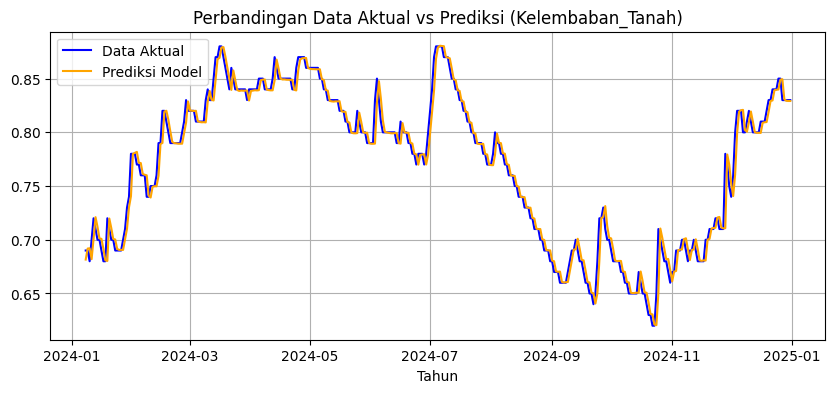

In [19]:
# Ambil tanggal-tanggal dari indeks df yang sesuai dengan y_test
dates = df.index[split + time_steps:]

# Pastikan jumlah tanggal sama dengan panjang y_test
dates = dates[:len(y_test)]

# Plot dengan x = tanggal
plt.figure(figsize=(10, 4))
plt.plot(dates, y_test_inv, label='Data Aktual', color='blue')
plt.plot(dates, y_pred_inv, label='Prediksi Model', color='orange')
plt.xlabel('Tahun')
plt.ylabel(metrics_dict[feature])
plt.title(f"Perbandingan Data Aktual vs Prediksi ({feature_name})")
plt.grid(True)
plt.legend()
plt.show()